In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [3]:
from collections import Counter

In [4]:
from matplotlib.ticker import MaxNLocator

In [5]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [6]:
from collections import Counter

In [7]:
import relative_accuracy as ra
import MVA as ga
import geh as ga1
from statistics import mean, stdev

In [8]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [9]:
# Wide Data
Xtrain = joblib.load("002weeks_train.save") 
Xtest = joblib.load("002weeks_test.save") 

In [10]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [11]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [12]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [13]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [14]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

C:\Users\esugom\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [16]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6              # No of loop detectors
n_seq = 3                    # Subsequences
n_steps = 5                  # time-step per subsequence
val_percent = 0.07567        # 2 weeks
batch_size = 32

#### 5 mins

In [17]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [18]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [19]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [20]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [21]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [22]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [23]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [24]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [25]:
# define no_of_channels
n_channels = 1

In [26]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [27]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

# CNN-LSTM model

In [28]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [29]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

In [30]:
Wide_train_5.shape

(49233, 14)

# 5 mins ahead

In [31]:
model5 = keras.models.load_model("my_dir/7d-CNN-LSTM-5") 

### Evaluation on inverse_transform

In [32]:
test_predictions5 = model5.predict((Wv5,Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,3]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,3]

#MSE5 = mean_squared_error(yv5,test_predictions5)

#MAE5 = mean_absolute_error(yv5,test_predictions5)

#RMSE5 = np.sqrt(MSE5)

#MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

#eval5 = [MSE5, MAE5, RMSE5, MAPE5]
#print(eval5)

In [33]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[62.733383121732636, 79.71122728404282, 88.57356235997013]


In [34]:
GEH, num, actual, predicted = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH1, _ = ga1.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [35]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [36]:
actual = np.pad(actual, (1, 1), 'edge')
predicted = np.pad(predicted, (1, 1), 'edge')

In [37]:
x = np.arange(1,len(GEH)+1)
x1 = np.arange(1,len(GEH1)+1)

In [38]:
yv5 = np.pad(yv5[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
test_predictions5 = np.pad(test_predictions5[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
actual = np.pad(actual[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
predicted = np.pad(predicted[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

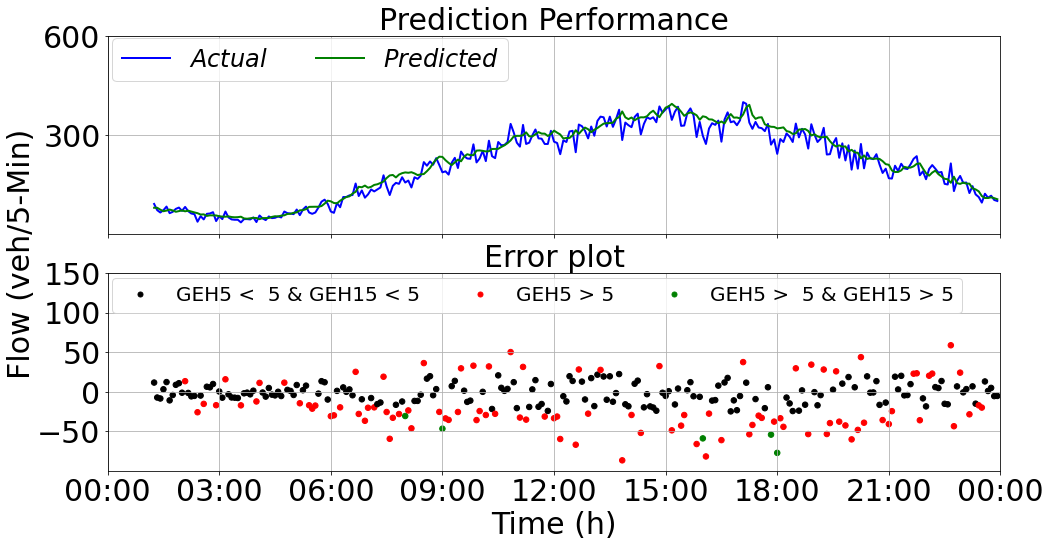

In [64]:
x= np.arange(0,288)
col = np.where(GEH>5, 'g', np.where(GEH1>5, 'r','k'))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

#set tick labels font size for y-axis only
# axes.tick_params(axis='y', which='both', labelsize=20)

# 1 Prediction plot
axes[0].plot(yv5, lw=2, label=r'$Actual$', color='blue')
axes[0].plot(test_predictions5, lw=2, label=r'$Predicted$', color='green')
axes[0].legend(bbox_to_anchor=(0.005,0.77,0.4,0.1), loc="lower left", mode=None, 
               borderaxespad=0, ncol=4, prop={'size': 24})
axes[0].set_title('Prediction Performance', fontsize=30)
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.08,-0.1)
axes[0].tick_params(axis='y', labelsize= 30)



# 2 Error plot
axes[1].scatter(x, (yv5-test_predictions5), s=30, c=col)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="black", 
                      markerfacecolor="black", label='GEH5 <  5 & GEH15 < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
line3, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="green", 
                      markerfacecolor="green", label='GEH5 >  5 & GEH15 > 5', ls="None")
axes[1].legend(handles=[line1, line2, line3], markerscale=500, bbox_to_anchor=(0.005,0.8,1,0.1), 
               loc="lower left", mode=None, borderaxespad=0, ncol=3, prop={'size': 20})
axes[1].set_title('Error plot', fontsize=30)
axes[1].grid()

# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
#y
axes[1].set_ylim(-100, 150)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='lower'))
axes[1].tick_params(axis='y', labelsize= 30)


plt.show()

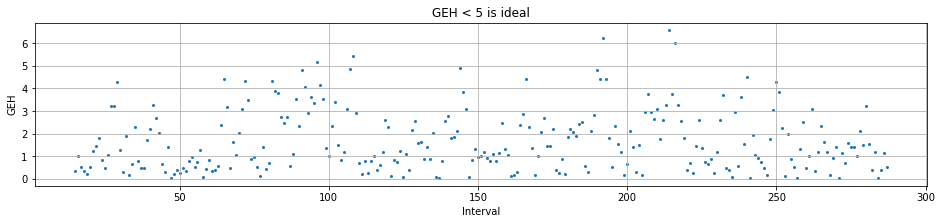

In [65]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [66]:
GEH5 = num/len(GEH)

# 15 mins ahead

In [67]:
model15 = keras.models.load_model("my_dir/7d-CNN-LSTM-15")

### Evaluation on inverse_transform

In [68]:
test_predictions15 = model15.predict((Wv15,Xv15))

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,3]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,3]

#MSE15 = mean_squared_error(yv15,test_predictions15)

#MAE15 = mean_absolute_error(yv15,test_predictions15)

#RMSE15 = np.sqrt(MSE15)

#MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

#eval15 = [MSE15, MAE15, RMSE15, MAPE15]
#print(eval15)

In [69]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[56.612702366127024, 75.04358655043588, 85.95267745952677]


In [70]:
GEH, num, actual, predicted = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))
GEH1, _ = ga1.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [71]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [72]:
actual = np.pad(actual, (1, 1), 'edge')
predicted = np.pad(predicted, (1, 1), 'edge')

In [73]:
x = np.arange(1,len(GEH)+1)
x1 = np.arange(1,len(GEH1)+1)

In [74]:
yv15 = np.pad(yv15[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
test_predictions15 = np.pad(test_predictions15[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
actual = np.pad(actual[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
predicted = np.pad(predicted[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

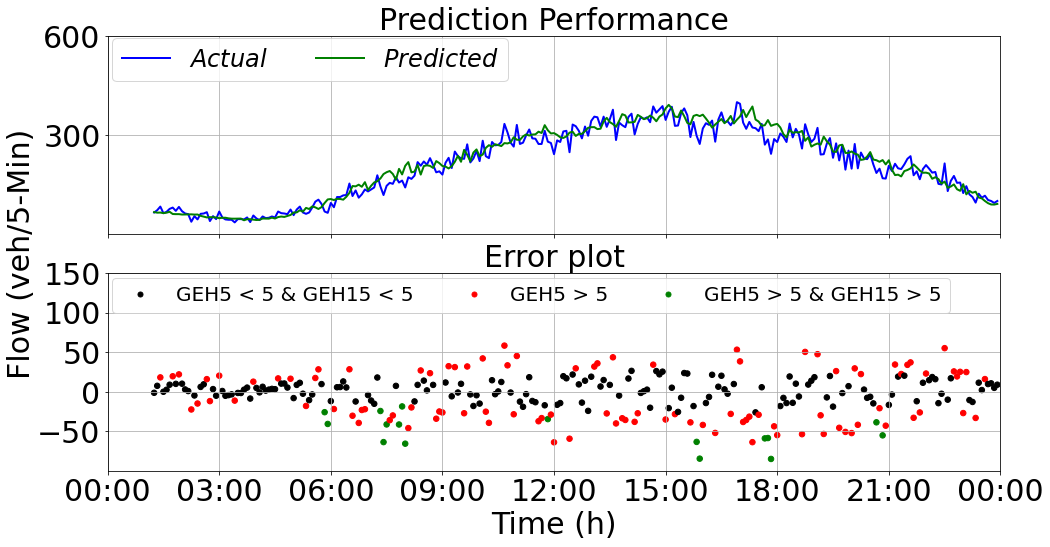

In [86]:
x= np.arange(0,288)
col = np.where(GEH>5, 'g', np.where(GEH1>5, 'r','k'))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

#set tick labels font size for y-axis only
# axes.tick_params(axis='y', which='both', labelsize=20)

# 1 Prediction plot
axes[0].plot(yv15, lw=2, label=r'$Actual$', color='blue')
axes[0].plot(test_predictions15, lw=2, label=r'$Predicted$', color='green')
axes[0].legend(bbox_to_anchor=(0.005,0.77,0.4,0.1), loc="lower left", mode=None, 
               borderaxespad=0, ncol=4, prop={'size': 24})
axes[0].set_title('Prediction Performance', fontsize=30)
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.08,-0.1)
axes[0].tick_params(axis='y', labelsize= 30)



# 2 Error plot
axes[1].scatter(x, (yv15-test_predictions15), s=30, c=col)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="black", 
                      markerfacecolor="black", label='GEH5 < 5 & GEH15 < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
line3, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="green", 
                      markerfacecolor="green", label='GEH5 > 5 & GEH15 > 5', ls="None")
axes[1].legend(handles=[line1, line2, line3], markerscale=500, bbox_to_anchor=(0.005,0.8,1,0.1), 
               loc="lower left", mode=None, borderaxespad=0, ncol=3, prop={'size': 20})
axes[1].set_title('Error plot', fontsize=30)
axes[1].grid()

# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
#y
axes[1].set_ylim(-100, 150)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='lower'))
axes[1].tick_params(axis='y', labelsize= 30)


plt.show()

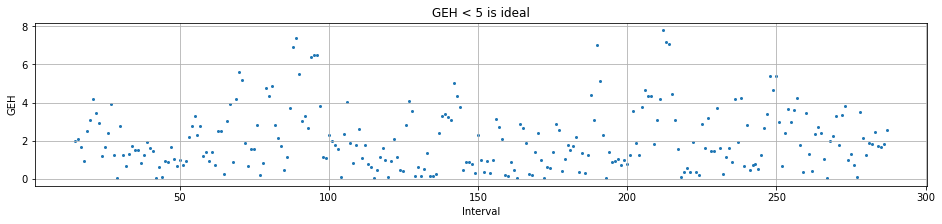

In [87]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [88]:
GEH15 = num/len(GEH)

# 30 mins ahead

In [73]:
model30 = keras.models.load_model("my_dir/7d-CNN-LSTM-30")

### Evaluation on inverse_transform

In [74]:
test_predictions30 = model30.predict((Wv30,Xv30))

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,3]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,3]

#MSE30 = mean_squared_error(yv30,test_predictions30)

#MAE30 = mean_absolute_error(yv30,test_predictions30)

#RMSE30 = np.sqrt(MSE30)

#MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

#eval30 = [MSE30, MAE30, RMSE30, MAPE30]
#print(eval30)

In [75]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[54.835493519441684, 73.678963110668, 84.37188434695912]


In [76]:
GEH, num, actual, predicted = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))
GEH1, _ = ga1.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [77]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [78]:
actual = np.pad(actual, (1, 1), 'edge')
predicted = np.pad(predicted, (1, 1), 'edge')

In [79]:
x = np.arange(1,len(GEH)+1)
x1 = np.arange(1,len(GEH1)+1)

In [80]:
yv30 = np.pad(yv30[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
test_predictions30 = np.pad(test_predictions30[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
actual = np.pad(actual[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
predicted = np.pad(predicted[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

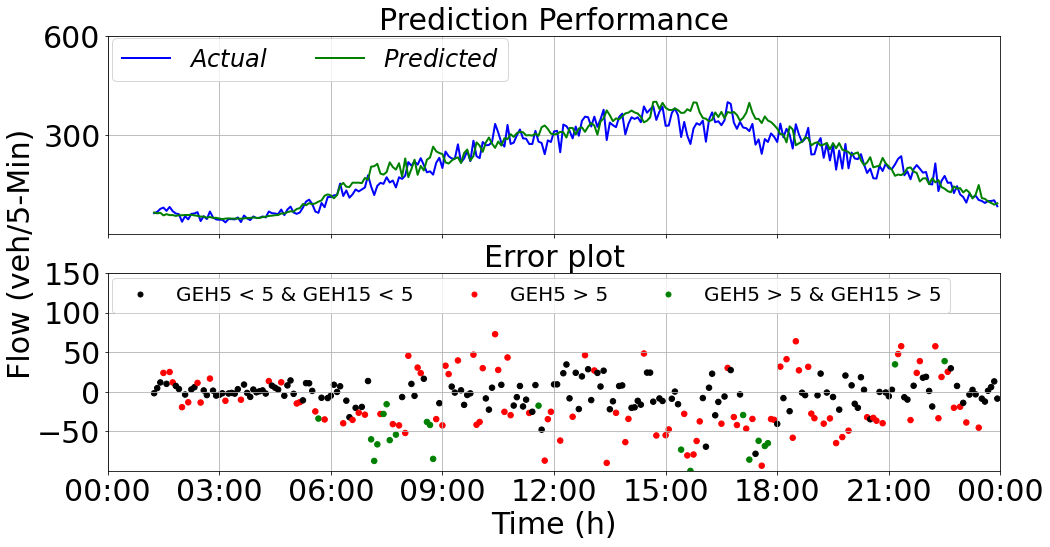

In [86]:
x= np.arange(0,288)
col = np.where(GEH>5, 'g', np.where(GEH1>5, 'r','k'))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

#set tick labels font size for y-axis only
# axes.tick_params(axis='y', which='both', labelsize=20)

# 1 Prediction plot
axes[0].plot(yv30, lw=2, label=r'$Actual$', color='blue')
axes[0].plot(test_predictions30, lw=2, label=r'$Predicted$', color='green')
axes[0].legend(bbox_to_anchor=(0.005,0.77,0.4,0.1), loc="lower left", mode=None, 
               borderaxespad=0, ncol=4, prop={'size': 24})
axes[0].set_title('Prediction Performance', fontsize=30)
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.08,-0.1)
axes[0].tick_params(axis='y', labelsize= 30)



# 2 Error plot
axes[1].scatter(x, (yv30-test_predictions30), s=30, c=col)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="black", 
                      markerfacecolor="black", label='GEH5 < 5 & GEH15 < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
line3, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="green", 
                      markerfacecolor="green", label='GEH5 > 5 & GEH15 > 5', ls="None")
axes[1].legend(handles=[line1, line2, line3], markerscale=500, bbox_to_anchor=(0.005,0.8,1,0.1), 
               loc="lower left", mode=None, borderaxespad=0, ncol=3, prop={'size': 20})
axes[1].set_title('Error plot', fontsize=30)
axes[1].grid()

# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
#y
axes[1].set_ylim(-100, 150)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='lower'))
axes[1].tick_params(axis='y', labelsize= 30)


plt.show()

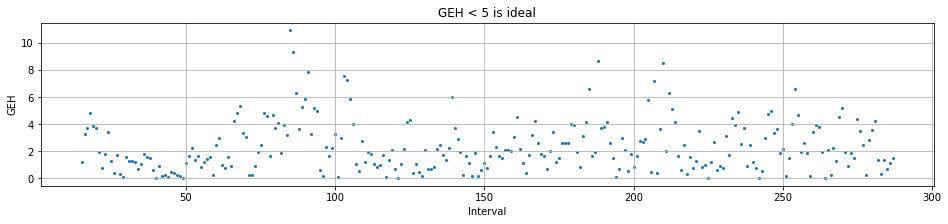

In [87]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [88]:
GEH30 = num/len(GEH)

# 60 mins ahead

In [89]:
model60 = keras.models.load_model("my_dir/7d-CNN-LSTM-60")

### Evaluation on inverse_transform

In [90]:
test_predictions60 = model60.predict((Wv60,Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,3]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,3]

#MSE60 = mean_squared_error(yv60,test_predictions60)

#MAE60 = mean_absolute_error(yv60,test_predictions60)

#RMSE60 = np.sqrt(MSE60)

#MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

#eval60 = [MSE60, MAE60, RMSE60, MAPE60]
#print(eval60)

In [91]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[49.57563654518223, 66.74987518721917, 79.13130304543185]


In [92]:
GEH, num, actual, predicted = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))
GEH1, _ = ga1.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [93]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [94]:
actual = np.pad(actual, (1, 1), 'edge')
predicted = np.pad(predicted, (1, 1), 'edge')

In [95]:
x = np.arange(1,len(GEH)+1)
x1 = np.arange(1,len(GEH1)+1)

In [96]:
yv60 = np.pad(yv60[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
test_predictions60 = np.pad(test_predictions60[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
actual = np.pad(actual[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
predicted = np.pad(predicted[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

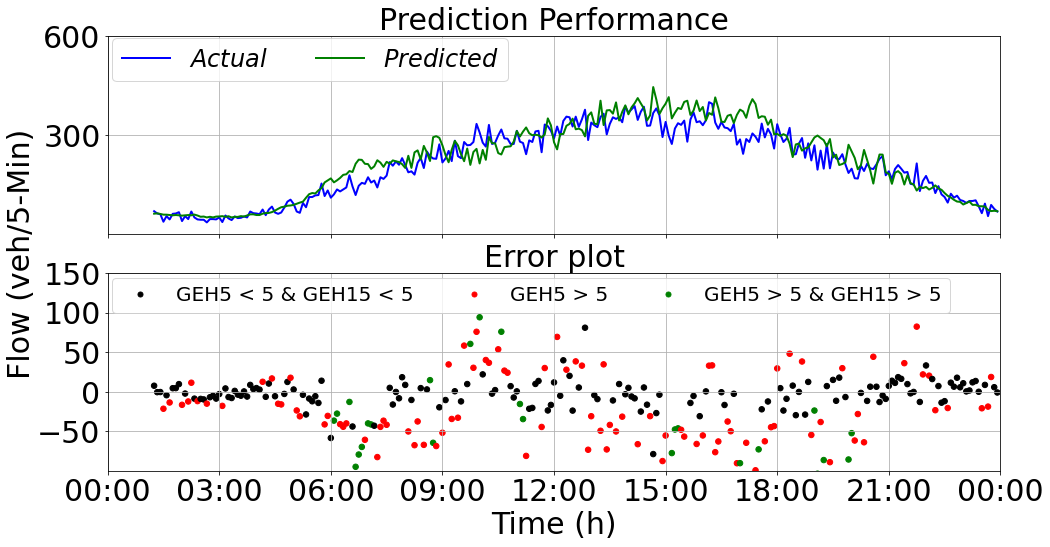

In [102]:
x= np.arange(0,288)
col = np.where(GEH>5, 'g', np.where(GEH1>5, 'r','k'))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

#set tick labels font size for y-axis only
# axes.tick_params(axis='y', which='both', labelsize=20)

# 1 Prediction plot
axes[0].plot(yv60, lw=2, label=r'$Actual$', color='blue')
axes[0].plot(test_predictions60, lw=2, label=r'$Predicted$', color='green')
axes[0].legend(bbox_to_anchor=(0.005,0.77,0.4,0.1), loc="lower left", mode=None, 
               borderaxespad=0, ncol=4, prop={'size': 24})
axes[0].set_title('Prediction Performance', fontsize=30)
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.08,-0.1)
axes[0].tick_params(axis='y', labelsize= 30)



# 2 Error plot
axes[1].scatter(x, (yv60-test_predictions60), s=30, c=col)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="black", 
                      markerfacecolor="black", label='GEH5 < 5 & GEH15 < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
line3, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="green", 
                      markerfacecolor="green", label='GEH5 > 5 & GEH15 > 5', ls="None")
axes[1].legend(handles=[line1, line2, line3], markerscale=500, bbox_to_anchor=(0.005,0.8,1,0.1), 
               loc="lower left", mode=None, borderaxespad=0, ncol=3, prop={'size': 20})
axes[1].set_title('Error plot', fontsize=30)
axes[1].grid()

# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
#y
axes[1].set_ylim(-100, 150)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='lower'))
axes[1].tick_params(axis='y', labelsize= 30)


plt.show()

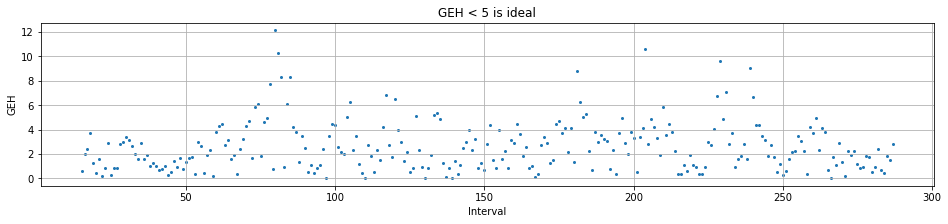

In [103]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [104]:
GEH60 = num/len(GEH)

## GEH

In [73]:
m = ["GEH5", "GEH15", "GEH30", "GEH60"]

In [74]:
GEH_ = [GEH5, GEH15, GEH30, GEH60]

In [75]:
data = np.asarray(GEH_).reshape((1, 4))
df = pd.DataFrame(data=data,columns=m)
df

,GEH5,GEH15,GEH30,GEH60
0,13.704861,12.892361,12.715278,11.864583


# Figure

In [76]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [77]:
col = np.where(GEH>5, 'r','b')
col1 = np.where(GEH1>5, 'r','b')

(array([  0,  36,  72, 108, 144, 180, 216, 252, 288]),
 [Text(0, 0, '00:00'),
  Text(36, 0, '03:00'),
  Text(72, 0, '06:00'),
  Text(108, 0, '09:00'),
  Text(144, 0, '12:00'),
  Text(180, 0, '15:00'),
  Text(216, 0, '18:00'),
  Text(252, 0, '21:00'),
  Text(288, 0, '00:00')])

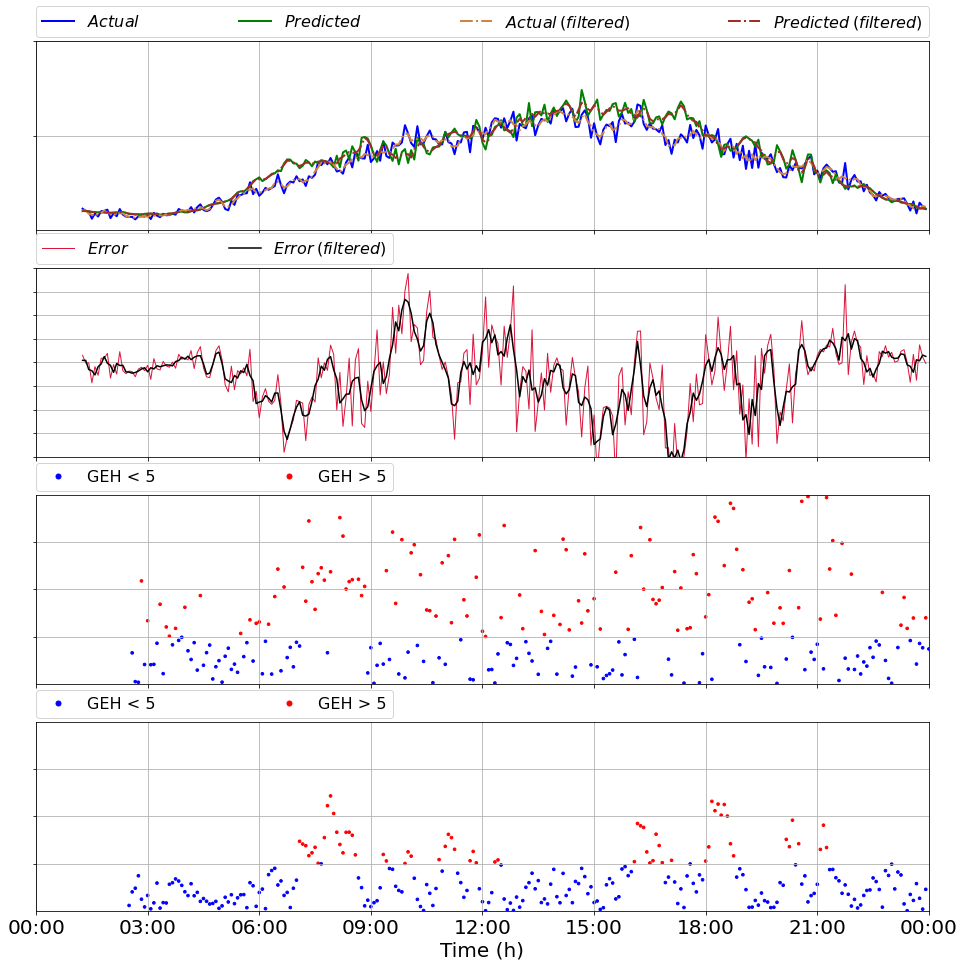

In [78]:
fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(16,16))


# 1 Prediction plot
axes[0].plot(yv60, lw=2, label=r'$Actual$', color='blue')
axes[0].plot(test_predictions60, lw=2, label=r'$Predicted$', color='green')
axes[0].plot(actual, lw=2, label=r'$Actual\:(filtered)$', color='peru', linestyle='dashdot')
axes[0].plot(predicted, lw=2, label=r'$Predicted\:(filtered)$', color='brown', linestyle='dashdot')

axes[0].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4, prop={'size': 16})
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
# axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=24)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.05,-0.1)
axes[0].set_yticklabels([])



# 2 Error plot
axes[1].plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='crimson')
axes[1].plot((actual-predicted), lw=1.5, label=r'$Error\:(filtered)$', color='black') 

axes[1].legend(bbox_to_anchor=(0,1.02,0.4,0.1), loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 16})
axes[1].grid()
# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels([])
#y
axes[1].set_ylim(-100, 100)
axes[1].set_yticklabels([])



# 3 GEH5 plot
axes[2].grid()
axes[2].scatter(x1[:288], GEH1, s=7, c=col1)
line1, = axes[2].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="blue", 
                      markerfacecolor="blue", label='GEH < 5', ls="None")
line2, = axes[2].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH > 5', ls="None")
axes[2].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.4,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 16})
# x
axes[2].set_xlim(0,288)
axes[2].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[2].set_xticklabels([])
# y
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
# axes[2].set_ylabel('GEH5', fontsize=24)
axes[2].set_ylim(0,20)
axes[2].yaxis.set_label_coords(-0.05,0.5)
axes[2].set_yticklabels([])



# 4 GEH5 plot
axes[3].grid()
axes[3].scatter(x[:288], GEH, s=7, c=col)

axes[3].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.4,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 16})
# x
axes[3].set_xlim(0,288)
axes[3].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[3].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=20)
axes[3].set_xlabel('Time (h)', fontsize=20)
# y
# axes[3].set_ylabel('GEH15', fontsize=24)
axes[3].set_ylim(0,20)
axes[3].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
axes[3].yaxis.set_label_coords(-0.05,0.5)
axes[3].set_yticklabels([])

plt.xticks(fontsize= 20)
# plt.yticks(fontsize= 20)